# TODO:

 - for `nturns` simulation, rotate start of lattice to place with vanishing $\alpha_{x,y}=0$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 3})
sns.set_style('whitegrid',
              {'grid.linestyle': ':', 'grid.color': 'red', 'axes.edgecolor': '0.5',
               'axes.linewidth': 1.2, 'legend.frameon': True})


In [2]:
from scipy.constants import e, m_p, c

from scipy.constants import physical_constants

In [3]:
from cpymad.madx import Madx

import pysixtracklib as pyst

In [4]:
nmass = physical_constants['atomic mass constant energy equivalent in MeV'][0] * 1e-3
nmass = 0.931494061 # MAD-X value

In [56]:
# hack fixing DriftExact
from pysixtracklib.beam_elements import Elements, DriftExact

Elements.element_types['Drift'] = DriftExact

# A. 18.88 equal tune case!

# Load linear MAD-X lattice for SIS100 (cold quads only)

In [5]:
madx = Madx()
madx.options.echo = False


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.04.02  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2018.10.03               +
  + Execution date: 2019.06.03 17:23:34      +
  ++++++++++++++++++++++++++++++++++++++++++++


In [6]:
madx.call(file="./2019-05-24--100turns-onlyquad/beam-distr.madx")

In [7]:
madxwarn = madx.options.warn
madx.options.warn = False
#madx.call(file=filename_error_table + '_full-lattice.seq')
# madx.call(file='./2019-05-23--100turns/SIS100RING_220618_nodipedge.thin.seq')
madx.call(file='./2019-05-24--100turns-onlyquad/SIS100QUADS.thin.seq')
madx.options.warn = madxwarn

In [8]:
madx.command.beam(particle='proton', energy=1)

True

In [9]:
madx.input('value, beam%sis100quads->gamma;')

beam%sis100quads->gamma =        1.065788933 ;


True

In [10]:
madx.input('value, beam%sis100quads->mass;')

beam%sis100quads->mass =       0.9382720813 ;


True

In [11]:
nmass_p = m_p/e*c**2
#nmass_p = 0.9382720813 * 1e9
nmass_p

938272081.4796857

In [12]:
Ekin = np.sqrt(1e9**2 - nmass_p**2)

In [13]:
# gamma recomputed to compare
np.sqrt((np.sqrt(1e9**2 - nmass_p**2) / nmass_p)**2 + 1)

1.065788932377661

In [14]:
madx.use(sequence='SIS100QUADS')

In [15]:
madx.input(
'''match, sequence=SIS100QUADS;
global, sequence=SIS100QUADS, q1=18.88, q2=18.88;
vary, name = kqf, step=0.0001;
vary, name = kqd, step=0.0001;
lmdif, tolerance=1e-20;
endmatch;
''')

START MATCHING

number of sequences: 1
sequence name: sis100quads
number of variables:    2
user given constraints: 2
total constraints:      2

START LMDIF:


MATCH SUMMARY

Node_Name                  Constraint   Type  Target Value       Final Value        Penalty
--------------------------------------------------------------------------------------------------


Final Penalty Function =   4.14120421e-24





Variable                 Final Value  Initial Value Lower Limit  Upper Limit 
--------------------------------------------------------------------------------
kqf                       1.92906e-01  1.92906e-01 -1.00000e+20  1.00000e+20
kqd                      -1.92906e-01 -1.92906e-01 -1.00000e+20  1.00000e+20

END MATCH SUMMARY

VARIABLE "TAR" SET TO   4.14120421e-24


True

In [16]:
madx.use(sequence='SIS100QUADS')

In [17]:
twiss = madx.twiss()

enter Twiss module

++++++ table: summ

            length             orbit5               alfa            gammatr 
            1083.6                 -0   -3.330669074e-16       -54794158.01 

                q1                dq1            betxmax              dxmax 
             18.88       -65.92076628        19.86530221                  0 

             dxrms             xcomax             xcorms                 q2 
                 0                  0                  0              18.88 

               dq2            betymax              dymax              dyrms 
      -65.92076628         19.8653033                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            synch_3            synch_4            synch_5 
                 0                  0                  0                  0 

            nflips 
          

In [18]:
sis100 = madx.sequence.SIS100QUADS

In [19]:
[f.name for f in map(lambda x: x.base_type, sis100.expanded_elements) 
 if 'drift' != f.name and 'multipole' != f.name and 'rfcavity' != f.name]

['marker', 'marker']

# Create MAD-X tracking files for comparison

In [20]:
nturns = 10000 #100 #2**16

In [21]:
# just for plotting reference
epsx = 35e-6 / 4 # geometrical emittances
epsy = 15e-6 / 4

In [22]:
madx.input('''
epsx_gauss=35e-6/4;
epsy_gauss=15e-6/4;
number_particles = 1000;
number_turns={:d};
ffile_stat=100;
gauss_cut=2;
'''.format(nturns))

True

### `nturns` turns:

In [23]:
madx.input("""
COPTION, SEED=987456321, PRINT=2;""")

True

In [24]:
madx.input('''
track, onepass,onetable;

n=0;
while(n<number_particles)
{
    exec, 6D_beam(gauss_cut,twiss);
    n=n+1;
}

run,turns=number_turns,ffile=ffile_stat;
endtrack;
''')

enter TRACK module
one pass is on
exit TRACK module



True

In [25]:
madx.command.write(table='tracksumm', file='madx_tracking_100turns.out')

True

### one turn, element by element:

In [26]:
madx.input("""
COPTION, SEED=987456321, PRINT=2;""")

True

In [27]:
madx.input('''
track, onepass, onetable, file=madx_tracking_oneturn.out;
'''
)

for elem_name in sis100.element_names()[1:-1]:
    madx.command.observe(place=elem_name)

madx.input('''
n=0;
while(n<number_particles)
{
    exec, 6D_beam(gauss_cut,twiss);
    n=n+1;
}

run,turns=1,ffile=1;
endtrack;
''')

enter TRACK module
one pass is on
exit TRACK module



True

# Load lattice and create beam in PySTL

In [29]:
elements = pyst.Elements.from_mad(sis100)

In [30]:
len(elements.get_elements())

339

In [32]:
elements.BeamMonitor(num_stores=1);

In [33]:
p0c = Ekin #238*0.2 * 1e9

In [34]:
npart = 1000
particles = pyst.Particles.from_ref(npart, p0c=p0c) #, q0=28, mass0=238*nmass*1e9)

In [35]:
particles.gamma0[0]

1.0657889324020815

In [36]:
madx.command.value('beam->gamma;')

beam->gamma        =        1.065788933 ;


True

# Load MAD-X tracking results, write initial coordinates into PySTL particles

In [37]:
filename_tracksumm = './madx_tracking_100turns.out'

In [38]:
initial_distribution = np.genfromtxt(
    filename_tracksumm, skip_header=8, max_rows=1000)

In [39]:
headers = list(np.genfromtxt(
    filename_tracksumm, skip_header=6, max_rows=1, dtype=str)[1:])

In [40]:
initial_distribution.shape

(1000, 10)

In [41]:
final_distribution = np.genfromtxt(
    filename_tracksumm, skip_header=8 + 1000,)

In [42]:
final_distribution.shape

(1000, 10)

In [43]:
assert final_distribution.shape == initial_distribution.shape

In [44]:
assert final_distribution[0, 1] == nturns

In [45]:
x = final_distribution[:, headers.index('X')]
xp = final_distribution[:, headers.index('PX')]
y = final_distribution[:, headers.index('Y')]
yp = final_distribution[:, headers.index('PY')]
z = final_distribution[:, headers.index('T')] * particles.beta0
dp = final_distribution[:, headers.index('PT')] / particles.beta0

In [46]:
print ('sig_x: {}\nsig_y: {}\nsig_z: {}\nsig_dp: {}'.format(
    np.std(x), np.std(y), np.std(z), np.std(dp)))

sig_x: 0.007909920923108348
sig_y: 0.0042460918831466
sig_z: 5.107673808090061
sig_dp: 0.0


In [47]:
x = initial_distribution[:, headers.index('X')]
xp = initial_distribution[:, headers.index('PX')]
y = initial_distribution[:, headers.index('Y')]
yp = initial_distribution[:, headers.index('PY')]
z = initial_distribution[:, headers.index('T')] * particles.beta0
dp = initial_distribution[:, headers.index('PT')] / particles.beta0

In [48]:
print ('sig_x: {}\nsig_y: {}\nsig_z: {}\nsig_dp: {}'.format(
    np.std(x), np.std(y), np.std(z), np.std(dp)))

sig_x: 0.008567296814283466
sig_y: 0.00345077169709805
sig_z: 0.0
sig_dp: 0.0


$\implies$ different beam sizes at the beginning and end, emittance exchange between planes!?

In [49]:
assert not any((
    np.any(twiss['r11']), np.any(twiss['r12']), 
    np.any(twiss['r21']), np.any(twiss['r22']))
)

$\implies$ TWISS doesn't indicate any global coupling (as for only quadrupoles there shouldn't be any!), so where does this effect come from? (Equal tunes here!)

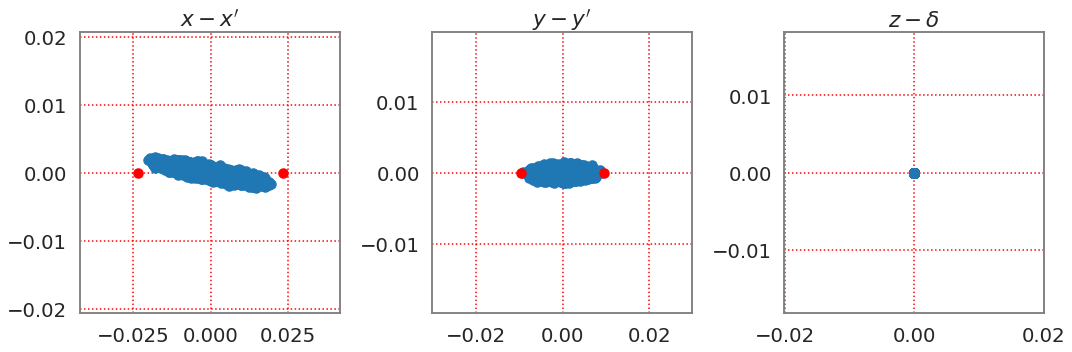

In [50]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

plt.sca(ax[0])
plt.title('$x-x\'$')
plt.scatter(x, xp)
plt.scatter([
    -np.sqrt(epsx * twiss['betx'][0]) * 2,
    np.sqrt(epsx * twiss['betx'][0]) * 2], [0,0], color='red')

plt.sca(ax[1])
plt.title('$y-y\'$')
plt.scatter(y, yp)
plt.scatter([
    -np.sqrt(epsy * twiss['bety'][0]) * 2,
    np.sqrt(epsy * twiss['bety'][0]) * 2], [0,0], color='red')

plt.sca(ax[2])
plt.title('$z-\delta$')
plt.scatter(z, dp)
plt.tight_layout()

In [51]:
particles.x *= 0
particles.px *= 0
particles.y *= 0
particles.py *= 0
particles.zeta *= 0
particles.delta *= 0

particles.x += x
particles.px += xp
particles.y += y
particles.py += yp
particles.zeta += z
particles.delta += dp

# PySTL tracking and comparison to MAD-X

## 1. element-by-element tracking for a single turn

In [52]:
job = pyst.TrackJob(elements, particles, device="opencl:1.0", until_turn_elem_by_elem=True)

In [53]:
job.track_elem_by_elem(1)

0

In [54]:
job.collect()

In [55]:
s = twiss['s'][::2]
beta_x = twiss['betx'][::2]
beta_y = twiss['bety'][::2]

p_id = 1

In [56]:
rec_x = job.output.particles[0].x
rec_y = job.output.particles[0].y

x_pystl = rec_x[p_id::npart][1:][::2]
y_pystl = rec_y[p_id::npart][1:][::2]

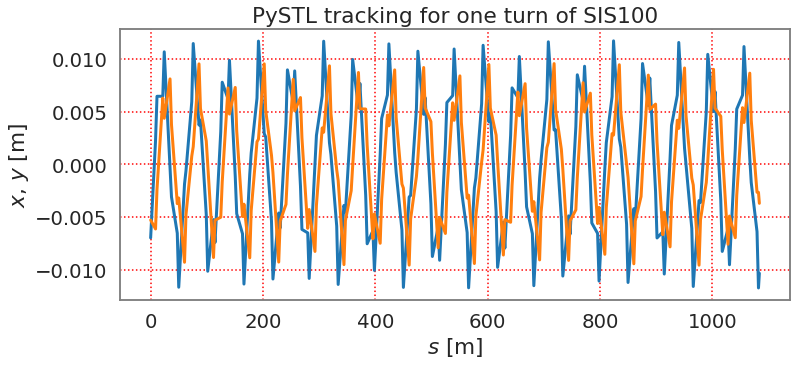

In [57]:
plt.figure(figsize=(12, 5))
plt.title('PySTL tracking for one turn of SIS100')
plt.xlabel('$s$ [m]')
plt.ylabel('$x$, $y$ [m]')
plt.plot(s, x_pystl)
plt.plot(s, y_pystl);

In [58]:
madx_ebye = np.genfromtxt('./madx_tracking_oneturn.outone', skip_header=54)

In [59]:
madx_ebye_headers = list(np.genfromtxt(
    './madx_tracking_oneturn.outone', skip_header=51, max_rows=1, dtype=str)[1:])

In [60]:
madx_ebye_elems = madx_ebye.reshape((len(sis100.elements), npart, madx_ebye.shape[1]))

In [61]:
x_madx = madx_ebye_elems[:, p_id, madx_ebye_headers.index('X')]
y_madx = madx_ebye_elems[:, p_id, madx_ebye_headers.index('Y')]

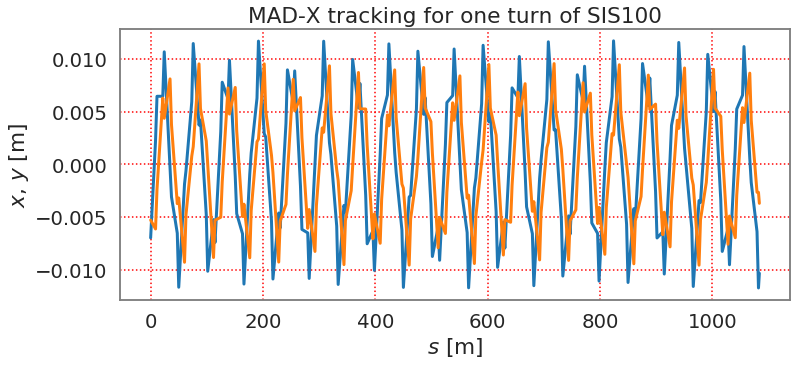

In [62]:
plt.figure(figsize=(12, 5))
plt.title('MAD-X tracking for one turn of SIS100')
plt.xlabel('$s$ [m]')
plt.ylabel('$x$, $y$ [m]')
plt.plot(s, x_madx)
plt.plot(s, y_madx);

### Comparison between PySTL and MAD-X

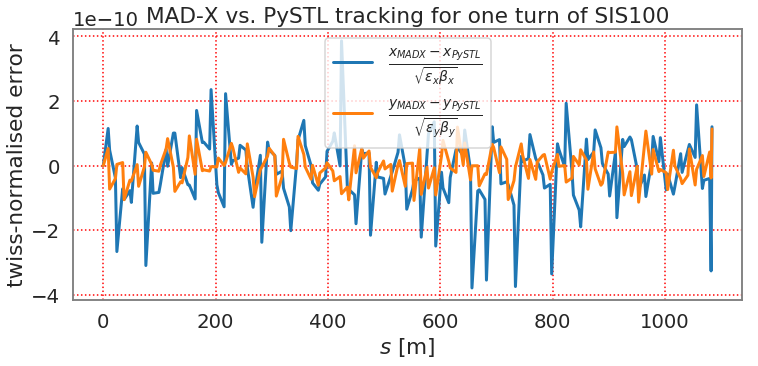

In [63]:
plt.figure(figsize=(12, 5))
plt.title('MAD-X vs. PySTL tracking for one turn of SIS100')
plt.xlabel('$s$ [m]')
plt.ylabel('twiss-normalised error')
plt.plot(s, (x_madx - x_pystl) / np.sqrt(epsx * beta_x), 
         label=r'$\frac{x_{MADX} - x_{PySTL}}{\sqrt{\epsilon_x\beta_x}}$')
plt.plot(s, (y_madx - y_pystl) / np.sqrt(epsy * beta_y), 
         label=r'$\frac{y_{MADX} - y_{PySTL}}{\sqrt{\epsilon_y\beta_y}}$')
plt.legend();
plt.savefig('tracking_madx_vs_pystl_optics-normalised.pdf', bbox_inches='tight')

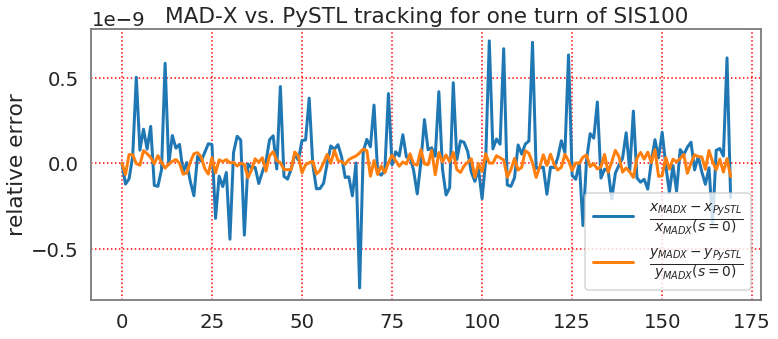

In [64]:
plt.figure(figsize=(12, 5))
plt.title('MAD-X vs. PySTL tracking for one turn of SIS100')
plt.ylabel('relative error')
plt.plot((x_madx - x_pystl) / x_madx[0], 
         label=r'$\frac{x_{MADX} - x_{PySTL}}{x_{MADX}(s=0)}$')
plt.plot((y_madx - y_pystl) / x_madx[0], 
         label=r'$\frac{y_{MADX} - y_{PySTL}}{y_{MADX}(s=0)}$')
plt.legend()
plt.savefig('tracking_madx_vs_pystl_optics-relative.pdf', bbox_inches='tight')

## 2. `nturns` tracking

In [66]:
del elements, job, particles

In [67]:
elements = pyst.Elements.from_mad(sis100)
elements.BeamMonitor(num_stores=nturns)

particles = pyst.Particles.from_ref(npart, p0c=p0c)

particles.x *= 0
particles.px *= 0
particles.y *= 0
particles.py *= 0
particles.zeta *= 0
particles.delta *= 0

particles.x += x
particles.px += xp
particles.y += y
particles.py += yp
particles.zeta += z
particles.delta += dp

In [68]:
job = pyst.TrackJob(elements, particles, device="opencl:0.0")

In [69]:
job.track(nturns)

0

In [70]:
job.collect()

In [71]:
rec_x = job.output.particles[0].x
rec_y = job.output.particles[0].y

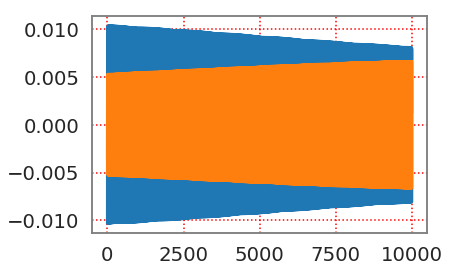

In [72]:
plt.plot(rec_x[1::npart])
plt.plot(rec_y[1::npart])

In [73]:
pbuffer = job.particles_buffer.get_object(0)

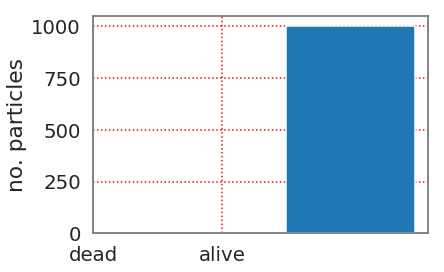

In [74]:
plt.hist(pbuffer.state, bins=2);
plt.ylabel('no. particles')
plt.xticks(ticks=[0.25, 0.75], labels=['dead', 'alive']);

In [73]:
# plt.title('fixed global aperture')
# plt.hist(pbuffer.at_element[~pbuffer.state.astype(bool)]);
# plt.ylabel('no. particles')
# plt.xlabel('no. element of loss');

In [74]:
# plt.hist(pbuffer.at_turn[~pbuffer.state.astype(bool)], bins=25);
# plt.yscale('log')
# plt.ylabel('no. particles')
# plt.xlabel('turn number of loss');

In [75]:
Qx = twiss.summary['q1']
qx = Qx % 1
qx = qx if qx < 0.5 else 1 - qx

Qy = twiss.summary['q2']
qy = Qy % 1
qy = qy if qy < 0.5 else 1 - qy

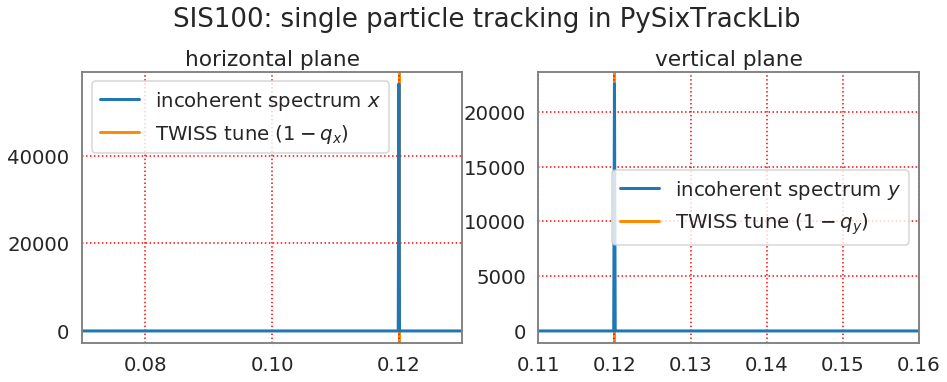

In [76]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

plt.sca(ax[0])
plt.title('horizontal plane')
plt.plot(
    np.fft.rfftfreq(len(rec_x[1::npart])),
    np.sum(np.abs(np.fft.rfft(rec_x.reshape(nturns, npart).T, axis=1)), axis=0),
    label=r'incoherent spectrum $x$'
)
plt.axvline(qx, color='darkorange', zorder=-1,
            label='TWISS tune $(1-q_x)$')
plt.xlim(qx - 0.05, qx + 0.01)
plt.legend()

plt.sca(ax[1])
plt.title('vertical plane')
plt.plot(
    np.fft.rfftfreq(len(rec_y[1::npart])),
    np.sum(np.abs(np.fft.rfft(rec_y.reshape(nturns, npart).T, axis=1)), axis=0),
    label=r'incoherent spectrum $y$'
)
plt.axvline(qy, color='darkorange', zorder=-1,
            label='TWISS tune $(1-q_y)$')
plt.xlim(qy - 0.01, qy + 0.04)
plt.legend()

plt.suptitle('SIS100: single particle tracking in PySixTrackLib', y=1.06, fontsize=26);
# plt.savefig('./pystl_sis100_tunes.pdf', bbox_inches='tight')

In [78]:
x = final_distribution[:, headers.index('X')]
xp = final_distribution[:, headers.index('PX')]
y = final_distribution[:, headers.index('Y')]
yp = final_distribution[:, headers.index('PY')]
z = final_distribution[:, headers.index('T')] * particles.beta0
dp = final_distribution[:, headers.index('PT')] / particles.beta0

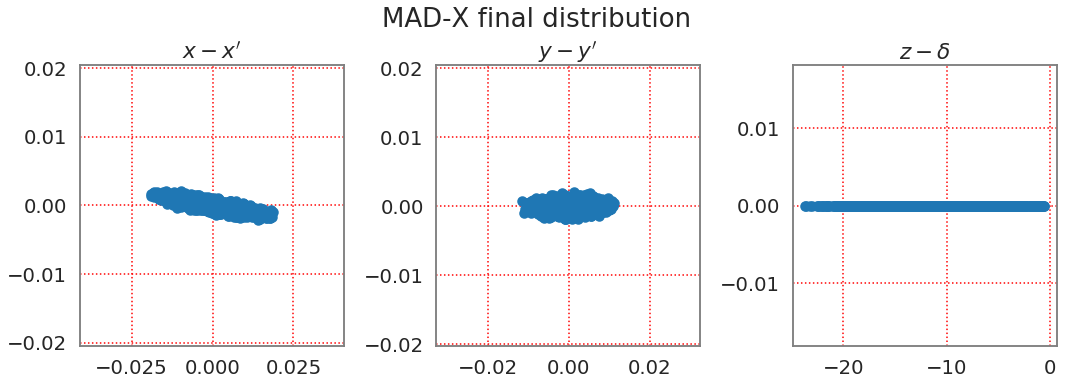

In [79]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

plt.suptitle('MAD-X final distribution', fontsize=26, y=1.06)

plt.sca(ax[0])
plt.title('$x-x\'$')
plt.scatter(x, xp)

plt.sca(ax[1])
plt.title('$y-y\'$')
plt.scatter(y, yp)

plt.sca(ax[2])
plt.title('$z-\delta$')
plt.scatter(z, dp)
plt.tight_layout()

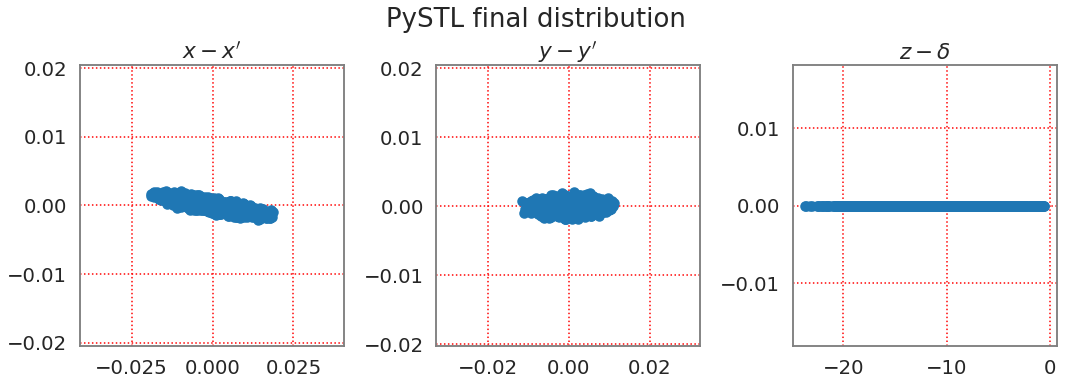

In [80]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

plt.suptitle('PySTL final distribution', fontsize=26, y=1.06)

plt.sca(ax[0])
plt.title('$x-x\'$')
plt.scatter(pbuffer.x, pbuffer.px)

plt.sca(ax[1])
plt.title('$y-y\'$')
plt.scatter(pbuffer.y, pbuffer.py)

plt.sca(ax[2])
plt.title('$z-\delta$')
plt.scatter(pbuffer.zeta, pbuffer.delta)
plt.tight_layout()

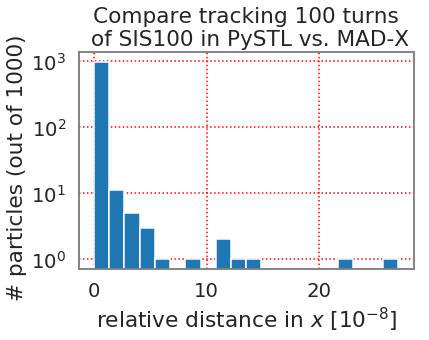

In [93]:
plt.hist(
    np.abs((pbuffer.x - final_distribution[:, headers.index('X')]) / pbuffer.x) * 1e8, 
    bins=20);
plt.yscale('log')
plt.xlabel('relative distance in $x$ [$10^{-8}$]')
plt.ylabel('# particles (out of {})  '.format(npart));
plt.title('Compare tracking 100 turns\n of SIS100 in PySTL vs. MAD-X')
plt.savefig('./tracking_madx_vs_pystl_x.pdf', bbox_inches='tight');

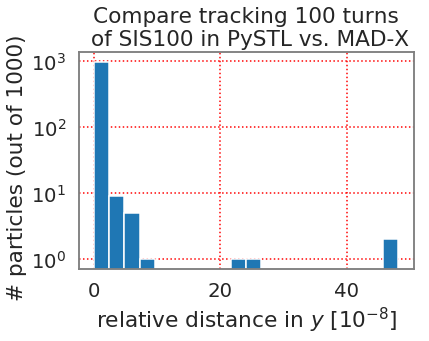

In [94]:
plt.hist(
    np.abs((pbuffer.y - final_distribution[:, headers.index('Y')]) / pbuffer.y) * 1e8, 
    bins=20);
plt.yscale('log')
plt.xlabel('relative distance in $y$ [$10^{-8}$]')
plt.ylabel('# particles (out of {})  '.format(npart));
plt.title('Compare tracking 100 turns\n of SIS100 in PySTL vs. MAD-X')
plt.savefig('./tracking_madx_vs_pystl_y.pdf', bbox_inches='tight');

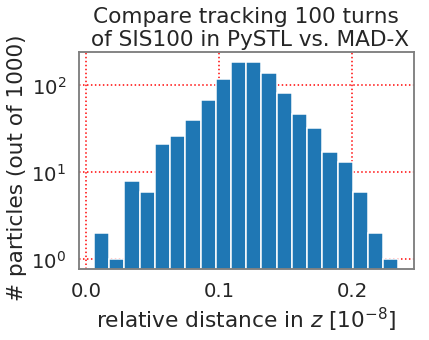

In [95]:
plt.hist(
    np.abs((pbuffer.zeta - final_distribution[:, headers.index('T')] * particles.beta0) / pbuffer.zeta) * 1e8, 
    bins=20);
plt.yscale('log')
plt.xlabel(u'relative distance in $z$ [$10^{-8}$]')
plt.ylabel('# particles (out of {})  '.format(npart));
plt.title('Compare tracking 100 turns\n of SIS100 in PySTL vs. MAD-X')
plt.savefig('./tracking_madx_vs_pystl_z.pdf', bbox_inches='tight');

# B. qx=18.84 and qy=18.73 tune case!

In [6]:
madx = Madx()
madx.options.echo = False


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.04.02  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2018.10.03               +
  + Execution date: 2019.06.03 17:23:40      +
  ++++++++++++++++++++++++++++++++++++++++++++


In [7]:
madx.call(file="./2019-05-24--100turns-onlyquad/beam-distr.madx")

In [8]:
madxwarn = madx.options.warn
madx.options.warn = False
#madx.call(file=filename_error_table + '_full-lattice.seq')
# madx.call(file='./2019-05-23--100turns/SIS100RING_220618_nodipedge.thin.seq')
madx.call(file='./2019-05-24--100turns-onlyquad/SIS100QUADS.thin.seq')
madx.options.warn = madxwarn

In [9]:
madx.command.beam(particle='proton', energy=1)

True

In [10]:
madx.command.use(sequence='sis100quads')

True

In [11]:
madx.input(
'''match, sequence=SIS100QUADS;
global, sequence=SIS100QUADS, q1=18.84, q2=18.73;
vary, name = kqf, step=0.0001;
vary, name = kqd, step=0.0001;
lmdif, tolerance=1e-20;
endmatch;
''')

START MATCHING

number of sequences: 1
sequence name: sis100quads
number of variables:    2
user given constraints: 2
total constraints:      2

START LMDIF:


MATCH SUMMARY

Node_Name                  Constraint   Type  Target Value       Final Value        Penalty
--------------------------------------------------------------------------------------------------


Final Penalty Function =   7.47209049e-25





Variable                 Final Value  Initial Value Lower Limit  Upper Limit 
--------------------------------------------------------------------------------
kqf                       1.92343e-01  1.92906e-01 -1.00000e+20  1.00000e+20
kqd                      -1.91859e-01 -1.92906e-01 -1.00000e+20  1.00000e+20

END MATCH SUMMARY

VARIABLE "TAR" SET TO   7.47209049e-25


True

In [12]:
madx.use(sequence='sis100quads')

In [13]:
twiss = madx.twiss()

enter Twiss module

++++++ table: summ

            length             orbit5               alfa            gammatr 
            1083.6                 -0   -3.330669074e-16       -54794158.01 

                q1                dq1            betxmax              dxmax 
             18.84       -65.56238211        19.83794075                  0 

             dxrms             xcomax             xcorms                 q2 
                 0                  0                  0              18.73 

               dq2            betymax              dymax              dyrms 
      -65.33441444        19.88231545                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            synch_3            synch_4            synch_5 
                 0                  0                  0                  0 

            nflips 
          

# Create MAD-X tracking files for comparison

In [14]:
nturns = 10000 #100 #2**16

In [15]:
madx.input('''
epsx_gauss=35e-6/4;
epsy_gauss=15e-6/4;
number_particles = 1000;
number_turns={:d};
ffile_stat=100;
gauss_cut=2;
'''.format(nturns))

True

### `nturns` turns:

In [16]:
madx.input("""
COPTION, SEED=987456321, PRINT=2;""")

True

In [16]:
madx.input('''
track, onepass,onetable;

n=0;
while(n<number_particles)
{
    exec, 6D_beam(gauss_cut,twiss);
    n=n+1;
}

run,turns=number_turns,ffile=ffile_stat;
endtrack;
''')

enter TRACK module
one pass is on
exit TRACK module



True

In [17]:
madx.command.write(table='tracksumm', file='madx_tracking_100turns_decoupled.out')

True

### one turn, element by element:

In [18]:
madx.input("""
COPTION, SEED=987456321, PRINT=2;""")

True

In [19]:
sis100 = madx.sequence.SIS100QUADS

In [20]:
madx.input('''
track, onepass, onetable, file=madx_tracking_oneturn_decoupled.out;
'''
)

for elem_name in sis100.element_names()[1:-1]:
    madx.command.observe(place=elem_name)

madx.input('''
n=0;
while(n<number_particles)
{
    exec, 6D_beam(gauss_cut,twiss);
    n=n+1;
}

run,turns=1,ffile=1;
endtrack;
''')

enter TRACK module
one pass is on
exit TRACK module



True

# Load lattice and create beam in PySTL

In [57]:
elements = pyst.Elements.from_mad(sis100)

In [58]:
len(elements.get_elements())

339

In [59]:
elements.BeamMonitor(num_stores=1);

In [60]:
nmass_p = m_p/e*c**2
#nmass_p = 0.9382720813 * 1e9
nmass_p

938272081.4796857

In [61]:
Ekin = np.sqrt(1e9**2 - nmass_p**2)

In [62]:
p0c = Ekin #238*0.2 * 1e9

In [63]:
npart = 1000
particles = pyst.Particles.from_ref(npart, p0c=p0c) #, q0=28, mass0=238*nmass*1e9)

In [64]:
particles.gamma0[0]

1.0657889324020815

In [65]:
madx.command.value('beam->gamma;')

beam->gamma        =        1.065788933 ;


True

# Load MAD-X tracking results, write initial coordinates into PySTL particles

In [66]:
filename_tracksumm = './madx_tracking_100turns_decoupled.out'

In [30]:
initial_distribution = np.genfromtxt(
    filename_tracksumm, skip_header=8, max_rows=1000)

In [31]:
headers = list(np.genfromtxt(
    filename_tracksumm, skip_header=6, max_rows=1, dtype=str)[1:])

In [32]:
initial_distribution.shape

(1000, 10)

In [33]:
final_distribution = np.genfromtxt(
    filename_tracksumm, skip_header=8 + 1000,)

In [34]:
final_distribution.shape

(1000, 10)

In [35]:
assert final_distribution.shape == initial_distribution.shape

In [36]:
assert final_distribution[0, 1] == nturns

In [37]:
x = final_distribution[:, headers.index('X')]
xp = final_distribution[:, headers.index('PX')]
y = final_distribution[:, headers.index('Y')]
yp = final_distribution[:, headers.index('PY')]
z = final_distribution[:, headers.index('T')] * particles.beta0
dp = final_distribution[:, headers.index('PT')] / particles.beta0

In [38]:
print ('sig_x: {}\nsig_y: {}\nsig_z: {}\nsig_dp: {}'.format(
    np.std(x), np.std(y), np.std(z), np.std(dp)))

sig_x: 0.008777209223804906
sig_y: 0.0035882961467016026
sig_z: 5.078969328689036
sig_dp: 0.0


In [39]:
x = initial_distribution[:, headers.index('X')]
xp = initial_distribution[:, headers.index('PX')]
y = initial_distribution[:, headers.index('Y')]
yp = initial_distribution[:, headers.index('PY')]
z = initial_distribution[:, headers.index('T')] * particles.beta0
dp = initial_distribution[:, headers.index('PT')] / particles.beta0

In [40]:
print ('sig_x: {}\nsig_y: {}\nsig_z: {}\nsig_dp: {}'.format(
    np.std(x), np.std(y), np.std(z), np.std(dp)))

sig_x: 0.008564371112718485
sig_y: 0.0034698673785565895
sig_z: 0.0
sig_dp: 0.0


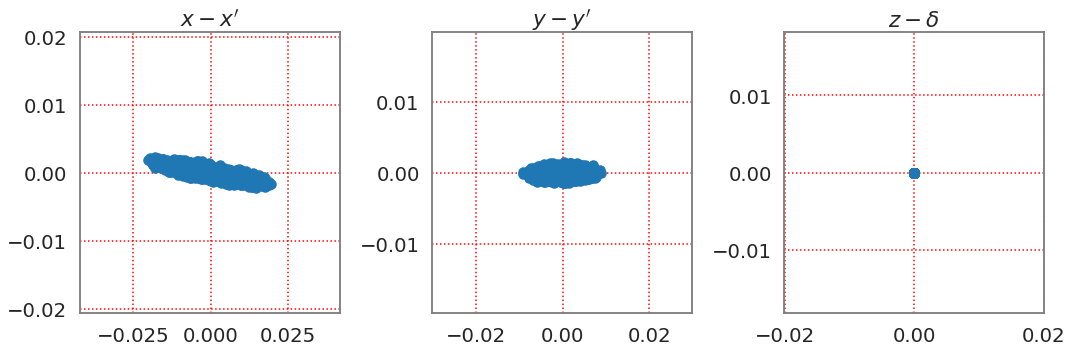

In [41]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

plt.sca(ax[0])
plt.title('$x-x\'$')
plt.scatter(x, xp)

plt.sca(ax[1])
plt.title('$y-y\'$')
plt.scatter(y, yp)

plt.sca(ax[2])
plt.title('$z-\delta$')
plt.scatter(z, dp)
plt.tight_layout()

In [67]:
particles.x *= 0
particles.px *= 0
particles.y *= 0
particles.py *= 0
particles.zeta *= 0
particles.delta *= 0

particles.x += x
particles.px += xp
particles.y += y
particles.py += yp
particles.zeta += z
particles.delta += dp

# PySTL tracking and comparison to MAD-X

## 1. element-by-element tracking for a single turn

In [68]:
job = pyst.TrackJob(elements, particles, device="opencl:1.0", until_turn_elem_by_elem=True)

In [69]:
job.track_elem_by_elem(1)

0

In [70]:
job.collect()

In [71]:
s = twiss['s'][::2]
beta_x = twiss['betx'][::2]
beta_y = twiss['bety'][::2]

p_id = 1

In [72]:
rec_x = job.output.particles[0].x
rec_y = job.output.particles[0].y

x_pystl = rec_x[p_id::npart][1:][::2]
y_pystl = rec_y[p_id::npart][1:][::2]

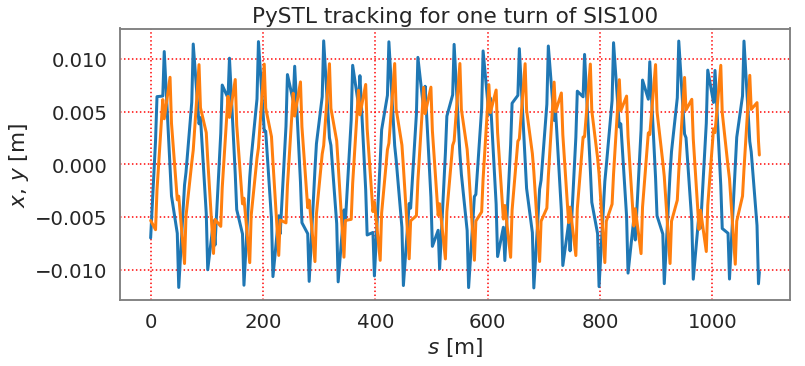

In [73]:
plt.figure(figsize=(12, 5))
plt.title('PySTL tracking for one turn of SIS100')
plt.xlabel('$s$ [m]')
plt.ylabel('$x$, $y$ [m]')
plt.plot(s, x_pystl)
plt.plot(s, y_pystl);

In [49]:
madx_ebye = np.genfromtxt('./madx_tracking_oneturn_decoupled.outone', skip_header=54)

In [50]:
madx_ebye_headers = list(np.genfromtxt(
    './madx_tracking_oneturn_decoupled.outone', skip_header=51, max_rows=1, dtype=str)[1:])

In [51]:
madx_ebye_elems = madx_ebye.reshape((len(sis100.elements), npart, madx_ebye.shape[1]))

In [52]:
x_madx = madx_ebye_elems[:, p_id, madx_ebye_headers.index('X')]
y_madx = madx_ebye_elems[:, p_id, madx_ebye_headers.index('Y')]

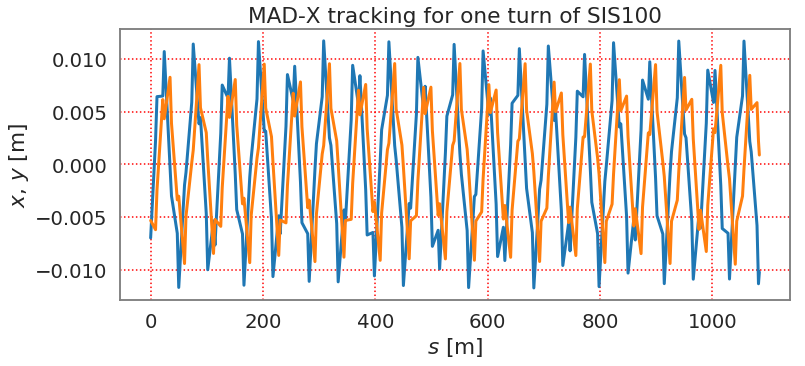

In [53]:
plt.figure(figsize=(12, 5))
plt.title('MAD-X tracking for one turn of SIS100')
plt.xlabel('$s$ [m]')
plt.ylabel('$x$, $y$ [m]')
plt.plot(s, x_madx)
plt.plot(s, y_madx);

### Comparison between PySTL and MAD-X

In [74]:
# just for plotting reference
epsx = 35e-6 / 4 # geometrical emittances
epsy = 15e-6 / 4

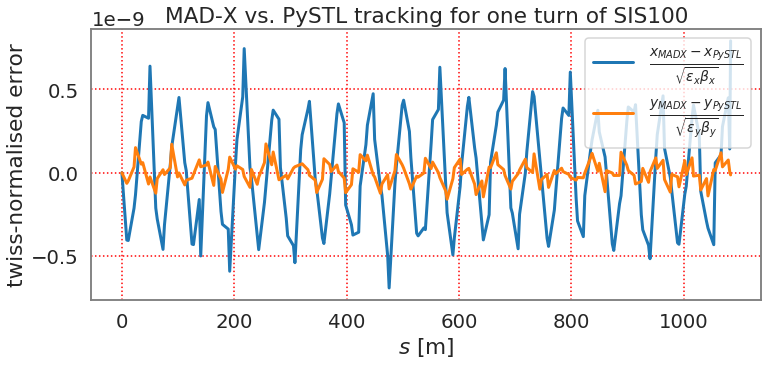

In [75]:
plt.figure(figsize=(12, 5))
plt.title('MAD-X vs. PySTL tracking for one turn of SIS100')
plt.xlabel('$s$ [m]')
plt.ylabel('twiss-normalised error')
plt.plot(s, (x_madx - x_pystl) / np.sqrt(epsx * beta_x), 
         label=r'$\frac{x_{MADX} - x_{PySTL}}{\sqrt{\epsilon_x\beta_x}}$')
plt.plot(s, (y_madx - y_pystl) / np.sqrt(epsy * beta_y), 
         label=r'$\frac{y_{MADX} - y_{PySTL}}{\sqrt{\epsilon_y\beta_y}}$')
plt.legend();
plt.savefig('tracking_madx_vs_pystl_optics-normalised_decoupled.pdf', bbox_inches='tight')

# C. far split qx=19.84 and qy=17.73 tune case!

In [76]:
madx = Madx()
madx.options.echo = False


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.04.02  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2018.10.03               +
  + Execution date: 2019.06.03 17:25:52      +
  ++++++++++++++++++++++++++++++++++++++++++++


In [77]:
madx.call(file="./2019-05-24--100turns-onlyquad/beam-distr.madx")

In [78]:
madxwarn = madx.options.warn
madx.options.warn = False
#madx.call(file=filename_error_table + '_full-lattice.seq')
# madx.call(file='./2019-05-23--100turns/SIS100RING_220618_nodipedge.thin.seq')
madx.call(file='./2019-05-24--100turns-onlyquad/SIS100QUADS.thin.seq')
madx.options.warn = madxwarn

In [79]:
madx.command.beam(particle='proton', energy=1)

True

In [80]:
madx.command.use(sequence='sis100quads')

True

In [81]:
madx.input(
'''match, sequence=SIS100QUADS;
global, sequence=SIS100QUADS, q1=19.84, q2=17.73;
vary, name = kqf, step=0.0001;
vary, name = kqd, step=0.0001;
lmdif, tolerance=1e-20;
endmatch;
''')

START MATCHING

number of sequences: 1
sequence name: sis100quads
number of variables:    2
user given constraints: 2
total constraints:      2

START LMDIF:


MATCH SUMMARY

Node_Name                  Constraint   Type  Target Value       Final Value        Penalty
--------------------------------------------------------------------------------------------------


Final Penalty Function =   1.26217745e-26





Variable                 Final Value  Initial Value Lower Limit  Upper Limit 
--------------------------------------------------------------------------------
kqf                       1.96852e-01  1.92906e-01 -1.00000e+20  1.00000e+20
kqd                      -1.87579e-01 -1.92906e-01 -1.00000e+20  1.00000e+20

END MATCH SUMMARY

VARIABLE "TAR" SET TO   1.26217745e-26


True

In [82]:
madx.use(sequence='sis100quads')

In [83]:
twiss = madx.twiss()

enter Twiss module

++++++ table: summ

            length             orbit5               alfa            gammatr 
            1083.6                 -0   -3.330669074e-16       -54794158.01 

                q1                dq1            betxmax              dxmax 
             19.84       -67.85165598        19.50396529                  0 

             dxrms             xcomax             xcorms                 q2 
                 0                  0                  0              17.73 

               dq2            betymax              dymax              dyrms 
      -63.47543646        20.35935654                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            synch_3            synch_4            synch_5 
                 0                  0                  0                  0 

            nflips 
          

# Create MAD-X tracking files for comparison

In [73]:
nturns = 10000 #100 #2**16

In [74]:
madx.input('''
epsx_gauss=35e-6/4;
epsy_gauss=15e-6/4;
number_particles = 1000;
number_turns={:d};
ffile_stat=100;
gauss_cut=2;
'''.format(nturns))

True

### `nturns` turns:

In [75]:
madx.input("""
COPTION, SEED=987456321, PRINT=2;""")

True

In [76]:
madx.input('''
track, onepass,onetable;

n=0;
while(n<number_particles)
{
    exec, 6D_beam(gauss_cut,twiss);
    n=n+1;
}

run,turns=number_turns,ffile=ffile_stat;
endtrack;
''')

enter TRACK module
one pass is on
exit TRACK module



True

In [77]:
madx.command.write(table='tracksumm', file='madx_tracking_100turns_farsplit.out')

True

### one turn, element by element:

In [78]:
madx.input("""
COPTION, SEED=987456321, PRINT=2;""")

True

In [84]:
sis100 = madx.sequence.SIS100QUADS

In [80]:
madx.input('''
track, onepass, onetable, file=madx_tracking_oneturn_farsplit.out;
'''
)

for elem_name in sis100.element_names()[1:-1]:
    madx.command.observe(place=elem_name)

madx.input('''
n=0;
while(n<number_particles)
{
    exec, 6D_beam(gauss_cut,twiss);
    n=n+1;
}

run,turns=1,ffile=1;
endtrack;
''')

enter TRACK module
one pass is on
exit TRACK module



True

# Load lattice and create beam in PySTL

In [86]:
elements = pyst.Elements.from_mad(sis100)

In [87]:
len(elements.get_elements())

339

In [88]:
elements.BeamMonitor(num_stores=1);

In [89]:
nmass_p = m_p/e*c**2
#nmass_p = 0.9382720813 * 1e9
nmass_p

938272081.4796857

In [90]:
Ekin = np.sqrt(1e9**2 - nmass_p**2)

In [91]:
p0c = Ekin #238*0.2 * 1e9

In [92]:
npart = 1000
particles = pyst.Particles.from_ref(npart, p0c=p0c) #, q0=28, mass0=238*nmass*1e9)

In [93]:
particles.gamma0[0]

1.0657889324020815

In [94]:
madx.command.value('beam->gamma;')

beam->gamma        =        1.065788933 ;


True

# Load MAD-X tracking results, write initial coordinates into PySTL particles

In [95]:
filename_tracksumm = './madx_tracking_100turns_farsplit.out'

In [96]:
initial_distribution = np.genfromtxt(
    filename_tracksumm, skip_header=8, max_rows=1000)

In [97]:
headers = list(np.genfromtxt(
    filename_tracksumm, skip_header=6, max_rows=1, dtype=str)[1:])

In [98]:
initial_distribution.shape

(1000, 10)

In [99]:
final_distribution = np.genfromtxt(
    filename_tracksumm, skip_header=8 + 1000,)

In [100]:
final_distribution.shape

(1000, 10)

In [101]:
assert final_distribution.shape == initial_distribution.shape

In [102]:
assert final_distribution[0, 1] == nturns

In [103]:
x = final_distribution[:, headers.index('X')]
xp = final_distribution[:, headers.index('PX')]
y = final_distribution[:, headers.index('Y')]
yp = final_distribution[:, headers.index('PY')]
z = final_distribution[:, headers.index('T')] * particles.beta0
dp = final_distribution[:, headers.index('PT')] / particles.beta0

In [104]:
print ('sig_x: {}\nsig_y: {}\nsig_z: {}\nsig_dp: {}'.format(
    np.std(x), np.std(y), np.std(z), np.std(dp)))

sig_x: 0.008643861370511678
sig_y: 0.0037066090821168247
sig_z: 5.241543838236761
sig_dp: 0.0


In [105]:
x = initial_distribution[:, headers.index('X')]
xp = initial_distribution[:, headers.index('PX')]
y = initial_distribution[:, headers.index('Y')]
yp = initial_distribution[:, headers.index('PY')]
z = initial_distribution[:, headers.index('T')] * particles.beta0
dp = initial_distribution[:, headers.index('PT')] / particles.beta0

In [106]:
print ('sig_x: {}\nsig_y: {}\nsig_z: {}\nsig_dp: {}'.format(
    np.std(x), np.std(y), np.std(z), np.std(dp)))

sig_x: 0.008437984798580841
sig_y: 0.003584648849466806
sig_z: 0.0
sig_dp: 0.0


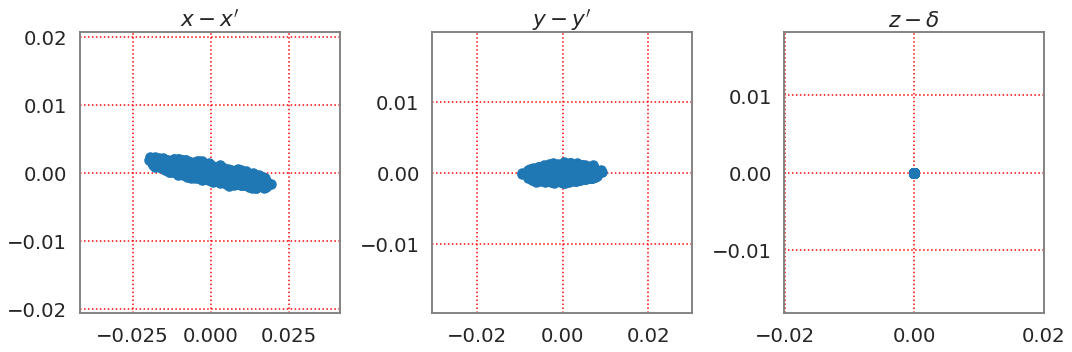

In [108]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

plt.sca(ax[0])
plt.title('$x-x\'$')
plt.scatter(x, xp)

plt.sca(ax[1])
plt.title('$y-y\'$')
plt.scatter(y, yp)

plt.sca(ax[2])
plt.title('$z-\delta$')
plt.scatter(z, dp)
plt.tight_layout()

In [109]:
particles.x *= 0
particles.px *= 0
particles.y *= 0
particles.py *= 0
particles.zeta *= 0
particles.delta *= 0

particles.x += x
particles.px += xp
particles.y += y
particles.py += yp
particles.zeta += z
particles.delta += dp

# PySTL tracking and comparison to MAD-X

## 1. element-by-element tracking for a single turn

In [110]:
job = pyst.TrackJob(elements, particles, device="opencl:1.0", until_turn_elem_by_elem=True)

In [111]:
job.track_elem_by_elem(1)

0

In [112]:
job.collect()

In [113]:
s = twiss['s'][::2]
beta_x = twiss['betx'][::2]
beta_y = twiss['bety'][::2]

p_id = 1

In [114]:
rec_x = job.output.particles[0].x
rec_y = job.output.particles[0].y

x_pystl = rec_x[p_id::npart][1:][::2]
y_pystl = rec_y[p_id::npart][1:][::2]

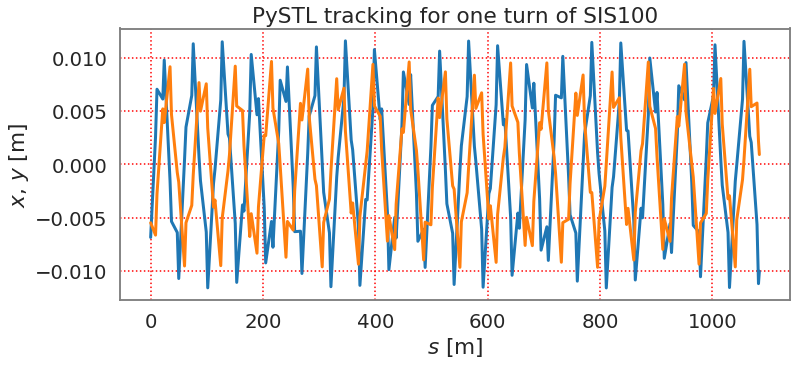

In [115]:
plt.figure(figsize=(12, 5))
plt.title('PySTL tracking for one turn of SIS100')
plt.xlabel('$s$ [m]')
plt.ylabel('$x$, $y$ [m]')
plt.plot(s, x_pystl)
plt.plot(s, y_pystl);

In [116]:
madx_ebye = np.genfromtxt('./madx_tracking_oneturn_farsplit.outone', skip_header=54)

In [117]:
madx_ebye_headers = list(np.genfromtxt(
    './madx_tracking_oneturn_farsplit.outone', skip_header=51, max_rows=1, dtype=str)[1:])

In [118]:
madx_ebye_elems = madx_ebye.reshape((len(sis100.elements), npart, madx_ebye.shape[1]))

In [119]:
x_madx = madx_ebye_elems[:, p_id, madx_ebye_headers.index('X')]
y_madx = madx_ebye_elems[:, p_id, madx_ebye_headers.index('Y')]

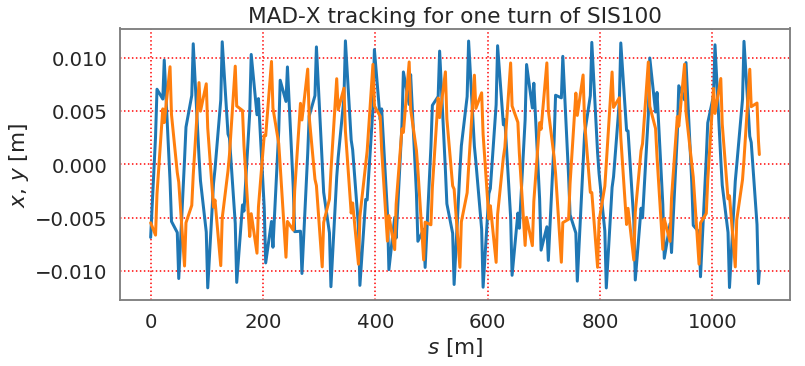

In [120]:
plt.figure(figsize=(12, 5))
plt.title('MAD-X tracking for one turn of SIS100')
plt.xlabel('$s$ [m]')
plt.ylabel('$x$, $y$ [m]')
plt.plot(s, x_madx)
plt.plot(s, y_madx);

### Comparison between PySTL and MAD-X

In [121]:
# just for plotting reference
epsx = 35e-6 / 4 # geometrical emittances
epsy = 15e-6 / 4

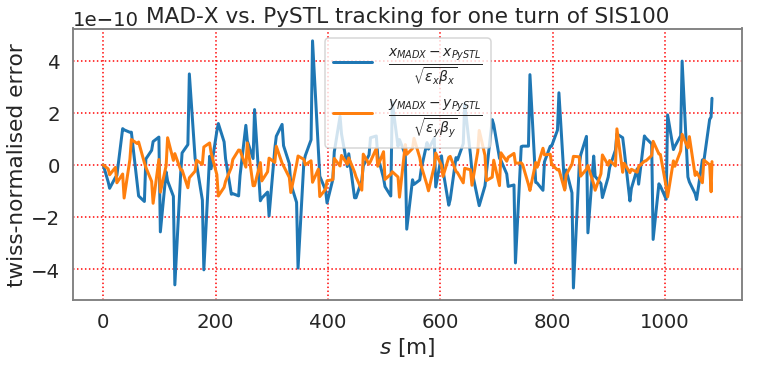

In [122]:
plt.figure(figsize=(12, 5))
plt.title('MAD-X vs. PySTL tracking for one turn of SIS100')
plt.xlabel('$s$ [m]')
plt.ylabel('twiss-normalised error')
plt.plot(s, (x_madx - x_pystl) / np.sqrt(epsx * beta_x), 
         label=r'$\frac{x_{MADX} - x_{PySTL}}{\sqrt{\epsilon_x\beta_x}}$')
plt.plot(s, (y_madx - y_pystl) / np.sqrt(epsy * beta_y), 
         label=r'$\frac{y_{MADX} - y_{PySTL}}{\sqrt{\epsilon_y\beta_y}}$')
plt.legend();
plt.savefig('tracking_madx_vs_pystl_optics-normalised_farsplit.pdf', bbox_inches='tight')

In [123]:
x = rec_x.reshape((len(elements.get_elements()), npart))[0]
y = rec_y.reshape((len(elements.get_elements()), npart))[0]

In [124]:
print ('sig_x: {}\nsig_y: {}\nsig_z: {}\nsig_dp: {}'.format(
    np.std(x), np.std(y), np.std(z), np.std(dp)))

sig_x: 0.008437984798580841
sig_y: 0.003584648849466806
sig_z: 0.0
sig_dp: 0.0


In [125]:
x = rec_x.reshape((len(elements.get_elements()), npart))[-1]
y = rec_y.reshape((len(elements.get_elements()), npart))[-1]

In [126]:
print ('sig_x: {}\nsig_y: {}\nsig_z: {}\nsig_dp: {}'.format(
    np.std(x), np.std(y), np.std(z), np.std(dp)))

sig_x: 0.008781191476601427
sig_y: 0.003732393259305808
sig_z: 0.0
sig_dp: 0.0


In [127]:
0.00878128/0.008437984

1.0406845995441565